# ENGR-E 533 Deep Learning Systems - Assignment 4

## Name : Akhila Sakiramolla (asakiram@iu.edu)
## UID : 2000886005

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import librosa
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers.core import Dense, Activation
from keras.callbacks import History 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout,LSTM, GRU
from tensorflow.keras.optimizers import Adam

# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Problem 1: Network Compression Using SVD

In [2]:
# Loading the data

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape
y_train.shape
x_test.shape
y_test.shape

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

In [3]:
# Reshaping the data

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [4]:
# Normalizing the data

x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
# Converting labels to categorical

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [36]:
# Building a model and adding 5 hidden layers with 1024 hidden units and output layer with 10 units

model = Sequential()
model.add(Dense(1024, input_dim = 784, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal()))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1024)              803840    
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_21 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_22 (Dense)            (None, 10)                10250     
                                                                 
Total params: 5,012,490
Trainable params: 5,012,490
No

For the base model, the total number of parameters = 5,012,490

In [7]:
# Calculating loss and optimizing it

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Fitting the model

history = History()
model.fit(x_train, y_train, epochs=70, batch_size=512, validation_data=(x_test,y_test))

Epoch 1/70
118/118 [==============================] - 2s 10ms/step - loss: 0.2795 - accuracy: 0.9154 - val_loss: 0.0967 - val_accuracy: 0.9705
Epoch 2/70
118/118 [==============================] - 1s 7ms/step - loss: 0.0765 - accuracy: 0.9758 - val_loss: 0.1122 - val_accuracy: 0.9663
Epoch 3/70
118/118 [==============================] - 1s 7ms/step - loss: 0.0508 - accuracy: 0.9840 - val_loss: 0.0756 - val_accuracy: 0.9770
Epoch 4/70
118/118 [==============================] - 1s 7ms/step - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.0824 - val_accuracy: 0.9768
Epoch 5/70
118/118 [==============================] - 1s 7ms/step - loss: 0.0287 - accuracy: 0.9907 - val_loss: 0.0936 - val_accuracy: 0.9752
Epoch 6/70
118/118 [==============================] - 1s 7ms/step - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.0926 - val_accuracy: 0.9766
Epoch 7/70
118/118 [==============================] - 1s 7ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 0.1008 - val_accuracy: 0.9759
Epoch

In [9]:
# Calculating test accuarcy 

loss_base, accuracy_base = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy_base*100,2))

313/313 [==============================] - 1s 3ms/step - loss: 0.1157 - accuracy: 0.9854
Test accuracy: 98.54


In [10]:
# Saving model weights

model.save_weights("model_weights.h5")

In [11]:
# Getting the weights and bias of the model

model_wts = []
model_bias = []
for i in range(len(model.layers)):
  model_wts.append(model.layers[i].get_weights()[0])
  model_bias.append(model.layers[i].get_weights()[1])

len(model_wts), len(model_bias)

(6, 6)

In [12]:
# Performing svd on weights

s = [[] for i in range(5)]
u = [[] for i in range(5)]
v = [[] for i in range(5)]

for i in range(5):
  s[i], u[i], v[i] = tf.linalg.svd(model_wts[i], compute_uv=True)

In [13]:
len(u[1])

1024

In [14]:
# Function to set model weights based on D value

def setWeights(D):
  for i in range(5):
      sv = tf.matmul(tf.linalg.diag(s[i][:D]), v[i][:,:D], adjoint_b=True)
      wts = tf.matmul(u[i][:,:D], sv)
      model.layers[i].set_weights((wts,model_bias[i]))

In [15]:
accuracy_vals = []

In [16]:
# Setting weights for D=10
D=10
setWeights(D)

# Calculating test accuarcy 
loss1, accuracy1 = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy1*100,2))
accuracy_vals.append(accuracy1)

313/313 [==============================] - 1s 2ms/step - loss: 1.6351 - accuracy: 0.6418
Test accuracy: 64.18


The total number of parameters when D = 10 is:
10x1024 + 1024 + 10x1024 + 1024 + 10x1024 + 1024 + 10x1024 + 1024 + 10x1024 + 1024 + 10x1024 =  66,560

This is 1.3% of base model parameters. 

In [17]:
# Setting weights for D=20
D=20
setWeights(D)

# Calculating test accuarcy 
loss2, accuracy2 = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy2*100,2))
accuracy_vals.append(accuracy2)

313/313 [==============================] - 1s 3ms/step - loss: 0.3744 - accuracy: 0.9213
Test accuracy: 92.13


The total number of parameters when D = 20 is:
20x1024 + 1024 + 20x1024 + 1024 + 20x1024 + 1024 + 20x1024 + 1024 + 20x1024 + 1024 + 10x1024 = 117,760

This is 2.3% of base model parameters.

In [18]:
# Setting weights for D=50
D=50
setWeights(D)

# Calculating test accuarcy 
loss3, accuracy3 = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy3*100,2))
accuracy_vals.append(accuracy3)

313/313 [==============================] - 1s 2ms/step - loss: 0.1085 - accuracy: 0.9813
Test accuracy: 98.13


The total number of parameters when D = 20 is:
50x1024 + 1024 + 50x1024 + 1024 + 50x1024 + 1024 + 50x1024 + 1024 + 50x1024 + 1024 + 10x1024 = 271,360

This is 5.4% of base model parameters.

In [19]:
# Setting weights for D=100
D=100
setWeights(D)

# Calculating test accuarcy 
loss4, accuracy4 = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy4*100,2))
accuracy_vals.append(accuracy4)

313/313 [==============================] - 1s 3ms/step - loss: 0.1026 - accuracy: 0.9841
Test accuracy: 98.41


The total number of parameters when D = 20 is:
100x1024 + 1024 + 100x1024 + 1024 + 100x1024 + 1024 + 100x1024 + 1024 + 100x1024 + 1024 + 10x1024 = 527,360

This is 10.5% of base model parameters.

In [20]:
# Setting weights for D=200
D=200
setWeights(D)

# Calculating test accuarcy 
loss5, accuracy5 = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy5*100,2))
accuracy_vals.append(accuracy5)

313/313 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9855
Test accuracy: 98.55


The total number of parameters when D = 200 is:
200x1024 + 1024 + 200x1024 + 1024 + 200x1024 + 1024 + 200x1024 + 1024 + 200x1024 + 1024 + 10x1024 = 1,039,360

This is 20.7% of base model parameters.


In [21]:
# Setting weights for D=Full
D=1024

for i in range(5):
       #first layer
      if i==0:
        sv = tf.matmul(tf.linalg.diag(s[i][:784]), v[i][:,:784], adjoint_b=True)
        wts = tf.matmul(u[i][:,:784], sv)
        model.layers[i].set_weights((wts,model_bias[i]))
      
      else:
        sv = tf.matmul(tf.linalg.diag(s[i][:D]), v[i][:,:D], adjoint_b=True)
        wts = tf.matmul(u[i][:,:D], sv)
        model.layers[i].set_weights((wts,model_bias[i]))


# Calculating test accuarcy 
loss6, accuracy6 = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy6*100,2))
accuracy_vals.append(accuracy6)

313/313 [==============================] - 1s 3ms/step - loss: 0.1157 - accuracy: 0.9854
Test accuracy: 98.54


The total number of parameters when D = 200 is: 784x1024 + 1024 + 1024x1024 + 1024 + 1024x1024 + 1024 + 1024x1024 + 1024 + 1024x1024 + 1024 + 10x1024 = 5,012,490

This is same as the number of base model parameters.

In [22]:
accuracy_vals.append(accuracy_base)
accuracy_vals

[0.6417999863624573,
 0.9212999939918518,
 0.9812999963760376,
 0.9840999841690063,
 0.9854999780654907,
 0.9854000210762024,
 0.9854000210762024]

<Figure size 864x576 with 0 Axes>

Text(0.5, 0, 'Dimension values')

Text(0, 0.5, 'Test Accuracy')

Text(0.5, 1.0, 'SVD Networks Performance')

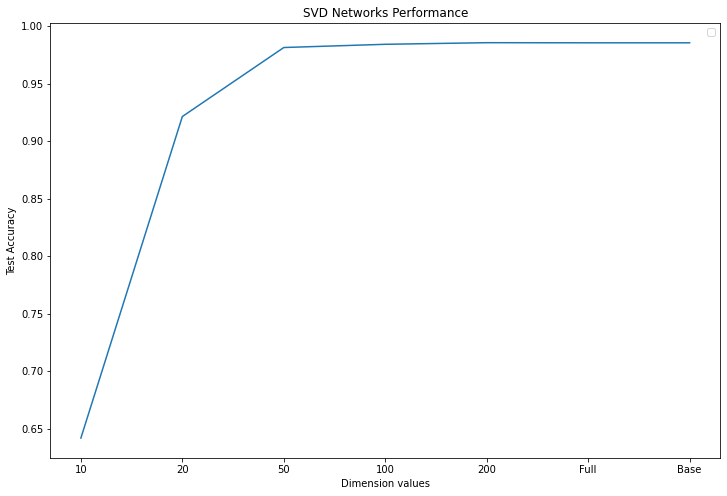

In [23]:
# Plotting the test accuracies

df_accuracy = pd.DataFrame(list(zip(['10', '20', '50', '100', '200', 'Full', 'Base'], accuracy_vals)), columns =['D_vals', 'Accuracy_vals'])
plt.figure(figsize=(12,8))
plt.plot(df_accuracy['D_vals'], df_accuracy['Accuracy_vals'])
plt.xlabel('Dimension values')
plt.ylabel('Test Accuracy')
plt.title('SVD Networks Performance')
plt.legend()

## Problem 2: Network Compression Using SVD

In [24]:
# Getting the weights and bias of the model

model_wts = []
model_bias = []
for i in range(len(model.layers)):
  model_wts.append(model.layers[i].get_weights()[0])
  model_bias.append(model.layers[i].get_weights()[1])

len(model_wts), len(model_bias)

(6, 6)

In [25]:
# Performing svd on weights to get U, V

V = [[] for i in range(5)]
U = [[] for i in range(5)]

for i in range(5):
  s, u, v = tf.linalg.svd(model_wts[i], compute_uv=True)
  V[i] = tf.matmul(tf.linalg.diag(s[:20]), v[:,:20], adjoint_b=True)
  U[i] = u[:,:20]

In [26]:
len(U), len(V)

(5, 5)

In [27]:
for i in range(5):
  print(len(U[i]))

784
1024
1024
1024
1024


In [28]:
for i in range(5):
  print(len(V[i]))

20
20
20
20
20


In [29]:
# # Building a model 

# model = Sequential()
# model.add(Dense(1024, input_dim = 784,activation='relu'))
# model.add(Dense(1024, input_dim = 1024,activation='relu'))
# model.add(Dense(1024, input_dim = 1024,activation='relu'))
# model.add(Dense(1024, input_dim = 1024,activation='relu'))
# model.add(Dense(1024, input_dim = 1024,activation='relu'))
# model.add(Dense(20, input_dim = 1024,activation='relu'))
# model.add(Dense(20, input_dim = 20,activation='relu'))
# model.add(Dense(20, input_dim = 20,activation='relu'))
# model.add(Dense(20, input_dim = 20,activation='relu'))
# model.add(Dense(20, input_dim = 20,activation='relu'))
# model.add(Dense(10, input_dim = 20 ,activation='softmax'))

# model.summary()

In [30]:
# Building a model 

model = Sequential()
model.add(Dense(20, input_dim = 784,activation=None))
model.add(Dense(1024, input_dim = 20,activation='relu'))
model.add(Dense(20, input_dim = 1024,activation=None))
model.add(Dense(1024, input_dim = 20,activation='relu'))
model.add(Dense(20, input_dim = 1024,activation=None))
model.add(Dense(1024, input_dim = 20,activation='relu'))
model.add(Dense(20, input_dim = 1024,activation=None))
model.add(Dense(1024, input_dim = 20,activation='relu'))
model.add(Dense(20, input_dim = 1024,activation=None))
model.add(Dense(1024, input_dim = 20,activation='relu'))
model.add(Dense(10, input_dim =1024 ,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dense_7 (Dense)             (None, 1024)              21504     
                                                                 
 dense_8 (Dense)             (None, 20)                20500     
                                                                 
 dense_9 (Dense)             (None, 1024)              21504     
                                                                 
 dense_10 (Dense)            (None, 20)                20500     
                                                                 
 dense_11 (Dense)            (None, 1024)              21504     
                                                                 
 dense_12 (Dense)            (None, 20)               

This architecture resulted in the least number of parameters compared to others.

In [32]:
# Calculating loss and optimizing it

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Initialising the weights using U and V from SVD

u_ind = 0
v_ind = 0
for i in range(10):
  if i in [0,2,4,6,8]:
    model.layers[i].set_weights((U[u_ind], model_bias[u_ind][:20]))
    u_ind+=1
  else:
    model.layers[i].set_weights((V[v_ind],model_bias[v_ind]))
    v_ind+=1

In [34]:
# Fitting the model

model.fit(x_train, y_train, epochs=20, batch_size=100)

Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1963 - accuracy: 0.9454
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0840 - accuracy: 0.9770
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0717 - accuracy: 0.9811
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0592 - accuracy: 0.9837
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0521 - accuracy: 0.9856
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0429 - accuracy: 0.9879
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0402 - accuracy: 0.9891
Epoch 8/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0387 - accuracy: 0.9894
Epoch 9/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0374 - accuracy: 0.9895
Epoch 10/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0339 - accuracy: 0.9907

In [35]:
# Calculating test accuarcy 

loss, accuracy = model.evaluate(x_test,  y_test)
print("Test accuracy:", round(accuracy*100,2))

313/313 [==============================] - 1s 3ms/step - loss: 0.1258 - accuracy: 0.9774
Test accuracy: 97.74


## Problem 3: Network Compression Using SVD

In [38]:
# Loading the base model weights
model.load_weights('model_weights.h5')

# Getting the weights and bias of the base model
model_wts = []
model_bias = []
for i in range(6):
  model_wts.append(model.layers[i].get_weights()[0])
  model_bias.append(model.layers[i].get_weights()[1])

len(model_wts), len(model_bias)

(6, 6)

In [39]:
# Function to define custome derivative

@tf.custom_gradient
def SetCustomWeights(wt):
    s, u, v = tf.linalg.svd(wt, compute_uv=True, full_matrices=True)
    sv = tf.matmul(tf.linalg.diag(s[:20]), v[:,:20], adjoint_b=True)
    wts = tf.matmul(u[:,:20], sv)

    def grad(dy):
      gradient = tf.gradients(dy, wts)
      return gradient

    return wts, grad

In [40]:
# Function to create custom layers

class customLayers(keras.layers.Layer): 

     def __init__(self, units, layer_val, input_dim):
      super(customLayers, self).__init__()
      # w_init = tf.random_normal_initializer()
      self.units = units
      self.layer_val = layer_val
      self.w=tf.Variable(
            initial_value = model_wts[self.layer_val],
            trainable=True,
        )
      # b_init = tf.zeros_initializer()
      self.b=tf.Variable(
            initial_value = model_bias[self.layer_val],
            trainable=True,
        )
      
      def call(self, inputs):
          custom_wts1 = SetCustomWeights(self.w)  
          custom_wts = keras.activations.relu(tf.matmul(inputs, custom_wts1)+self.b)
          return custom_wts

Reference - https://keras.io/guides/making_new_layers_and_models_via_subclassing/

In [41]:
# Building a model and adding 4 hidden layers 

model = Sequential()
model.add(customLayers(units=1024, layer_val=0, input_dim=(784,)))
model.add(customLayers(units=1024, layer_val=1, input_dim=(1024,)))
model.add(customLayers(units=1024, layer_val=2, input_dim=(1024,)))
model.add(customLayers(units=1024, layer_val=3, input_dim=(1024,)))
model.add(customLayers(units=1024, layer_val=4, input_dim=(1024,)))
model.add(Dense(units=10,activation='softmax'))

In [42]:
# Calculating loss and optimizing it

lr = 0.0001
model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
# Fitting the model

model_hist=model.fit(x=x_train, y=y_train, epochs=100, batch_size=1000, validation_data=(x_test,y_test))

Epoch 1/100
60/60 [==============================] - 0s 5ms/step - loss: 0.2579 - accuracy: 0.9285 - val_loss: 0.2651 - val_accuracy: 0.9257
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2578 - accuracy: 0.9284 - val_loss: 0.2652 - val_accuracy: 0.9260
Epoch 3/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2577 - accuracy: 0.9284 - val_loss: 0.2651 - val_accuracy: 0.9257
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 0.9286 - val_loss: 0.2650 - val_accuracy: 0.9258
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2575 - accuracy: 0.9285 - val_loss: 0.2650 - val_accuracy: 0.9257
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2574 - accuracy: 0.9287 - val_loss: 0.2649 - val_accuracy: 0.9259
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 0.2572 - accuracy: 0.9285 - val_loss: 0.2649 - val_accuracy: 0.9258
Epoch 8/100
6

In [50]:
# Calculating test accuarcy 

loss, accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", round(accuracy*100,2))

313/313 [==============================] - 1s 2ms/step - loss: 0.2620 - accuracy: 0.9272
Test accuracy: 92.72


## Problem 4: Speaker Verification

In [51]:
# Loading the data

with open('hw4_trs.pkl','rb') as file:
  trs=pickle.load(file)

with open('hw4_tes.pkl','rb') as file:
  tes=pickle.load(file)

In [52]:
trs.shape, tes.shape

((500, 16180), (200, 22631))

In [53]:
# Coverting train signals into spectograms

trs_stft = []

for i in range(len(trs)):
  trs_S = librosa.stft(trs[i], n_fft=1024, hop_length=512)
  trs_abs = np.abs(trs_S)
  trs_stft.append(trs_abs)

trs_stft = np.array(trs_stft)
trs_stft.shape

(500, 513, 32)

In [54]:
# Coverting test signals into spectograms

tes_stft = []

for i in range(len(tes)):
  tes_S = librosa.stft(tes[i], n_fft=1024, hop_length=512)
  tes_abs = np.abs(tes_S)
  tes_stft.append(tes_abs)

tes_stft = np.array(tes_stft)
tes_stft.shape

(200, 513, 45)

In [55]:
# Function to sample positive pairs

def posSampling(spk_index, df):
  pos_data = []
  for i in spk_index:
    spk_list = [i for i in range(i,i+10)]
    pair1_index = np.random.choice(spk_list,size=45,replace=True)
    pair1_data = df[pair1_index]
    
    pair2_index = np.random.choice(spk_list,size=45,replace=True)
    pair2_data = df[pair2_index]
    
    if i==0:
      pos_data =  np.concatenate((pair1_data, pair2_data))
    else:
      pos_data = np.concatenate((pos_data, pair1_data, pair2_data))

  return pos_data


In [56]:
# Sampling postive pairs for train and test data

trs_speakers_index = []
for i in range(0,len(trs_stft),10):
  trs_speakers_index.append(i)
trs_pos_data = posSampling(trs_speakers_index, trs_stft)
trs_pos_data.shape

tes_speakers_index = []
for i in range(0,len(tes_stft),10):
  tes_speakers_index.append(i)
tes_pos_data = posSampling(tes_speakers_index, tes_stft)
tes_pos_data.shape

(4500, 513, 32)

(1800, 513, 45)

In [57]:
# Function to sample negtaive pairs

def negSampling(spk_index,total_list,df):
  neg_data = []
  for i in spk_index:
    spk_list = [i for i in range(i,i+10)]
    rem_spk_list = ([x for x in total_list if x not in set(spk_list)])

    pair1_index = np.random.choice(rem_spk_list,size=45,replace=False)
    pair1_data = df[pair1_index]
  
    pair2_index = np.random.choice(spk_list,size=45,replace=True)
    pair2_data = df[pair2_index]
  
    if i==0:
      neg_data =  np.concatenate((pair1_data, pair2_data))
    else:
      neg_data = np.concatenate((neg_data, pair1_data, pair2_data))
  
  return neg_data

In [58]:
# Sampling negative pairs for train and test data

trs_total_list = [i for i in range(0,len(trs_stft))]
trs_neg_data = negSampling(trs_speakers_index,trs_total_list,trs_stft)
trs_neg_data.shape

tes_total_list = [i for i in range(0,len(tes_stft))]
tes_neg_data = negSampling(tes_speakers_index,tes_total_list,tes_stft)
tes_neg_data.shape

(4500, 513, 32)

(1800, 513, 45)

In [59]:
# Creating labels for train and test data

trs_labels = []
for i in range(0,50):
  ones = np.ones((45,1))
  zeros = np.zeros((45,1))
  if i==0:
    trs_labels =  np.concatenate((ones, zeros))
  else:
    trs_labels = np.concatenate((trs_labels, ones, zeros))

tes_labels = []
for i in range(0,20):
  ones = np.ones((45,1))
  zeros = np.zeros((45,1))
  if i==0:
    tes_labels =  np.concatenate((ones, zeros))
  else:
    tes_labels = np.concatenate((tes_labels, ones, zeros))

len(trs_labels),len(tes_labels)

(4500, 1800)

In [76]:
# Function to build a Siamese model

def siameseModel(inputShape, embeddingDim=48):
  inputs = Input(inputShape) # Define input
  x = GRU(activation='tanh', units=64, return_sequences=False)(inputs) # Define layers
  outputs = Dense(embeddingDim)(x)   # Define output
  model = Model(inputs, outputs)  # Build the model
  return model

In [77]:
# Configuring the siamese network

pos_input = Input(shape=(None,513))
neg_input = Input(shape=(None,513))
featureExtractor = siameseModel((None,513))
embed_vec1 = featureExtractor(pos_input)
embed_vec2 = featureExtractor(neg_input)

In [78]:
# Fucntion to calculate the inner product of the two latent embedding vectors

def distanceCalc(input1, input2):
  dist = tf.multiply(input1, input2)
  return dist

In [79]:
# Constructing the siamese network

distance = distanceCalc(embed_vec1, embed_vec2)
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[pos_input, neg_input], outputs=outputs)

In [80]:
# Calculating loss and optimizing the model

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [81]:
# Changing the shape of train and test data

trs_pos_data1 = np.transpose(trs_pos_data,axes=(0,2,1))
trs_neg_data1 = np.transpose(trs_neg_data,axes=(0,2,1))
trs_pos_data1.shape, trs_neg_data1.shape

tes_pos_data1 = np.transpose(tes_pos_data,axes=(0,2,1))
tes_neg_data1 = np.transpose(tes_neg_data,axes=(0,2,1))
tes_pos_data1.shape, tes_neg_data1.shape

((4500, 32, 513), (4500, 32, 513))

((1800, 45, 513), (1800, 45, 513))

In [87]:
# Fitting the model

model.fit([trs_pos_data1, trs_neg_data1], trs_labels,
          validation_data=([tes_pos_data1, tes_neg_data1], tes_labels),
	        batch_size=100, 
	        epochs=10)

Epoch 1/10
45/45 [==============================] - 1s 26ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.3201 - val_accuracy: 0.6617
Epoch 2/10
45/45 [==============================] - 1s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.3008 - val_accuracy: 0.6661
Epoch 3/10
45/45 [==============================] - 1s 15ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.3568 - val_accuracy: 0.6617
Epoch 4/10
45/45 [==============================] - 1s 15ms/step - loss: 9.9403e-04 - accuracy: 1.0000 - val_loss: 2.3697 - val_accuracy: 0.6650
Epoch 5/10
45/45 [==============================] - 1s 15ms/step - loss: 9.0419e-04 - accuracy: 1.0000 - val_loss: 2.3658 - val_accuracy: 0.6650
Epoch 6/10
45/45 [==============================] - 1s 15ms/step - loss: 8.4350e-04 - accuracy: 1.0000 - val_loss: 2.4096 - val_accuracy: 0.6667
Epoch 7/10
45/45 [==============================] - 1s 15ms/step - loss: 7.8773e-04 - accuracy: 1.0000 - val_loss: 2.4777 - val_accuracy: 0.65

In [85]:
# Calculating test accuarcy 

preds = model.predict([tes_pos_data1,tes_neg_data1])
preds1 = preds>=0.5
accuracy = (sum(preds1 == tes_labels)/len(tes_labels))[0]
print("Test accuracy:", round(accuracy*100,2))

57/57 [==============================] - 0s 5ms/step
Test accuracy: 66.22


Reference - https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/